# <div style="padding:15px; background-color:#26344e; font-family:JetBrains Mono; font-weight:bold; color:#f2f2f0; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 10px 10px">Customer Segmentation</div>

In [116]:
import helperfunction as hf
import importlib
importlib.reload(hf)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

In [2]:
invoice_df = hf.create_df('invoice_data')
invoice_df.head()

Current work Directory C:\Users\jahna\OneDrive\Documents\GitHub\Customer-Segmentation\Code
File Path is  C:\Users\jahna\OneDrive\Documents\GitHub\Customer-Segmentation\Code\invoice_data


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# invoice_df = pd.read_csv('invoice_data.csv', encoding='unicode_escape')
# invoice_df['InvoiceDate'] = pd.to_datetime(invoice_df['InvoiceDate'])

In [4]:
print(f"Total observations (records): {invoice_df.shape[0]}")
print(f"\nTotal features: {invoice_df.shape[1]}")
print(f"\nNumber of Invoices: {invoice_df['InvoiceNo'].nunique()}")
print(f"\nNumber of Products: {invoice_df['StockCode'].nunique()}")
print(f"\nNumber of Customers: {invoice_df['CustomerID'].nunique()}")
print(f"\nNumber of Countries: {invoice_df['Country'].nunique()}")
print(f"\nMinimum Date: {invoice_df['InvoiceDate'].min()} - Maximum Date: {invoice_df['InvoiceDate'].max()}")

Total observations (records): 541909

Total features: 8

Number of Invoices: 25900

Number of Products: 4070

Number of Customers: 4372

Number of Countries: 38

Minimum Date: 2010-12-01 08:26:00 - Maximum Date: 2011-12-09 12:50:00


In [5]:
invoice_df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
invoice_df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [7]:
print(f"Number of Observations with negative Quantity: {invoice_df[(invoice_df.Quantity<0)].shape[0]}")

Number of Observations with negative Quantity: 10624


In [8]:
invoice_w_price_df = invoice_df.copy(deep=True)
invoice_w_price_df['price'] = invoice_df['Quantity']*invoice_df['UnitPrice']
temp = invoice_w_price_df[['InvoiceNo','price']].groupby(['InvoiceNo']).sum().reset_index()
print(f"\nMin Basket Price: {temp.price.min()}")
print(f"Max Basket Price: {temp.price.max()}")


Min Basket Price: -168469.6
Max Basket Price: 168469.6


In [9]:
temp = invoice_w_price_df[['CustomerID','price']].groupby(['CustomerID']).sum().reset_index()
print(temp.sort_values(by='price', ascending=0).head())
print(f"\nMin Purchase by customer: {temp.price.min()}")
print(f"Max Purchase customer: {temp.price.max()}")

      CustomerID      price
1703     14646.0  279489.02
4233     18102.0  256438.49
3758     17450.0  187482.17
1895     14911.0  132572.62
55       12415.0  123725.45

Min Purchase by customer: -4287.63
Max Purchase customer: 279489.02


In [10]:
temp = invoice_df.groupby('CustomerID')['InvoiceDate'].agg(['first', 'last'])
temp['Date_Difference'] = temp['last'] - temp['first']
print(f"\nAvg customer span: {temp['Date_Difference'].mean()}")


Avg customer span: 133 days 17:25:29.204025618


In [11]:
temp = invoice_df[['InvoiceNo','Quantity']].groupby(['InvoiceNo']).sum().reset_index()
print(f"\nMin Quantity by InvoiceNo: {temp.Quantity.min()}")
print(f"Max Quantity by InvoiceNo: {temp.Quantity.max()}")


Min Quantity by InvoiceNo: -80995
Max Quantity by InvoiceNo: 80995


# PreProcessing

In [12]:
invoice_df.drop_duplicates(inplace=True, keep='first')
invoice_df.shape

(536641, 8)

### Handling Missing Values

In [13]:
print(f"Number of observations with NULL CustomerID: {invoice_df[invoice_df.CustomerID.isnull()].shape[0]}")

Number of observations with NULL CustomerID: 135037


In [14]:
invoice_df[invoice_df.CustomerID.isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom


In [15]:
invoice_df.dropna(subset=['CustomerID'], inplace=True)
print("Number of Records after dropping Null CustomerID", invoice_df.shape)

Number of Records after dropping Null CustomerID (401604, 8)


In [16]:
invoice_df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

# EDA

## Countries

In [17]:
temp = invoice_df[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('No Of Countries : {}'.format(len(countries)))

No Of Countries : 37


In [18]:
data = dict(
    type='choropleth',
    locations=countries.index,
    locationmode='country names',
    z=countries,
    text=countries.index,
    colorbar={'title': '# Orders'},
    colorscale=[
        [0, 'rgb(224,255,255)'],
        [0.01, 'rgb(166,206,227)'],
        [0.02, 'rgb(31,120,180)'],
        [0.03, 'rgb(178,223,138)'],
        [0.05, 'rgb(51,160,44)'],
        [0.10, 'rgb(251,154,153)'],
        [0.20, 'rgb(255,255,0)'],
        [1, 'rgb(227,26,28)']
    ],
    reversescale=False
)

layout = dict(
    title='Number of orders per country',
    geo=dict(showframe=True, projection={'type': 'mercator'}),
    width=1000,  # Adjust the width of the plot
    height=800   # Adjust the height of the plot
)

# choromap = go.Figure(data=[data], layout=layout)
# iplot(choromap, validate=False)

## Stock Code

In [19]:
list_special_codes = invoice_df[invoice_df['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, invoice_df[invoice_df['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                
CRUK            -> CRUK Commission               


## Quantity

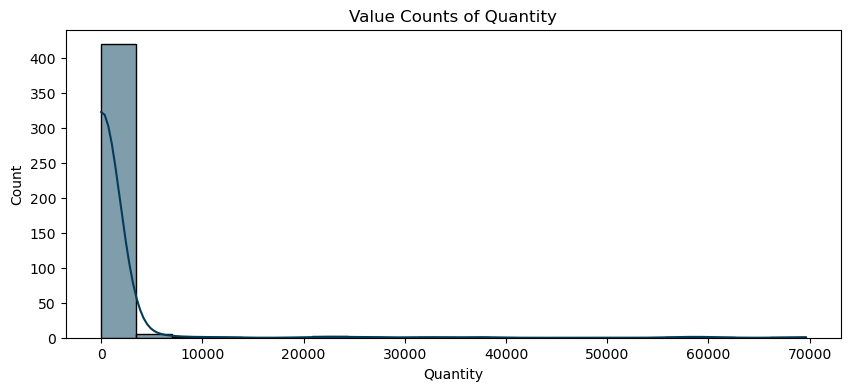

In [20]:
quantity_counts = invoice_df['Quantity'].value_counts()

# Plot the value counts
plt.figure(figsize=(10, 4))
sns.histplot(quantity_counts, bins=20, kde=True, color='#033C5A')
plt.title('Value Counts of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Count')
plt.show()

In [21]:
neg_invoice_df = invoice_df[invoice_df.Quantity<0]
print(f"Number of Negative Invoice records: {neg_invoice_df.shape[0]}")
neg_invoice_df.head()

Number of Negative Invoice records: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [22]:
neg_wo_cancel = neg_invoice_df[neg_invoice_df.InvoiceNo.str[:1] != 'C'].shape[0]
print(f"Number of Negative Invoice records without cancellations: {neg_wo_cancel}")

Number of Negative Invoice records without cancellations: 0


In [23]:
pos_invoice_df = invoice_df[invoice_df.Quantity>0]
print(f"Number of Positive Invoice records: {pos_invoice_df.shape[0]}")
pos_invoice_df.head()

Number of Positive Invoice records: 392732


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [24]:
pos_w_cancel = pos_invoice_df[pos_invoice_df.InvoiceNo.str[:1] == 'C'].shape[0]
print(f"Number of Positive Invoice records with cancellations: {pos_w_cancel}")

Number of Positive Invoice records with cancellations: 0


## Negative Quantity

In [25]:
# Cancellation Rate
cancellation_rate = len(neg_invoice_df) / len(invoice_df) * 100
print(f"Cancellation Rate: {cancellation_rate:.2f}%")

Cancellation Rate: 2.21%


In [26]:
# Impact on Revenue
total_revenue = invoice_df['UnitPrice'].sum()
cancelled_revenue = neg_invoice_df['UnitPrice'].sum()
revenue_impact = (cancelled_revenue / total_revenue) * 100
print(f"Impact on Revenue: {revenue_impact:.2f}%")

Impact on Revenue: 12.02%


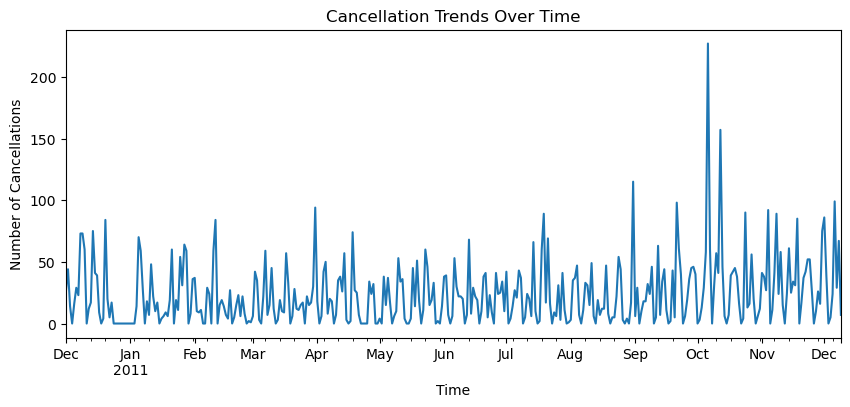

In [27]:
# Cancellation Trend
cancelled_orders = neg_invoice_df.copy()
cancelled_orders.set_index('InvoiceDate', inplace=True)
cancellation_trends = cancelled_orders.resample('D').size()
plt.figure(figsize=(10, 4))
cancellation_trends.plot(title='Cancellation Trends Over Time', ylabel='Number of Cancellations', xlabel='Time')
plt.show()

In [28]:
cancelled_orders['TotalPrice'] = cancelled_orders['UnitPrice'] * cancelled_orders['Quantity'].abs()
customer_cancellations = cancelled_orders.groupby('CustomerID').agg(
    cancel_cnt=('CustomerID', 'count'),
    cancel_amt=('TotalPrice', 'sum')   
).reset_index()
customer_cancellations.head()

,CustomerID,cancel_cnt,cancel_amt
0,12346.0,1,77183.60
1,12352.0,10,960.63
2,12359.0,6,127.05
3,12362.0,8,71.65
4,12365.0,1,320.69


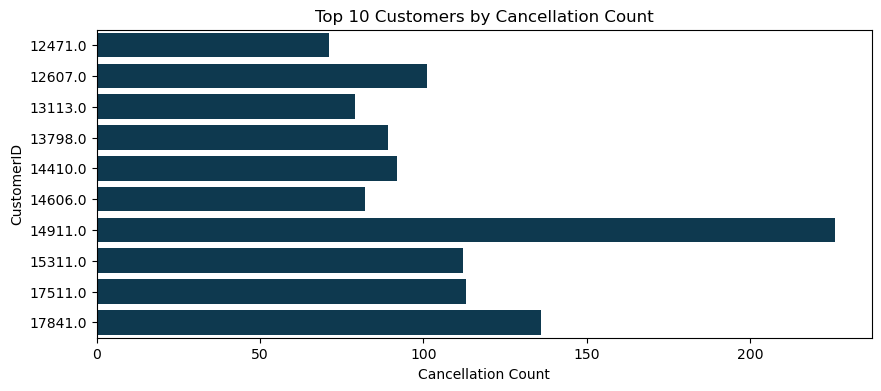

In [29]:
# Customer Analysis
customer_analysis = cancelled_orders.groupby('CustomerID').size().reset_index(name='CancellationCount')
top_customers = customer_analysis.sort_values(by='CancellationCount', ascending=False).head(10)

# Visualize Top 10 Customers with horizontal bar chart
plt.figure(figsize=(10, 4))
sns.barplot(y='CustomerID', x='CancellationCount', data=top_customers, orient='h', color='#033C5A')
plt.title('Top 10 Customers by Cancellation Count')
plt.xlabel('Cancellation Count')
plt.ylabel('CustomerID')
plt.show()

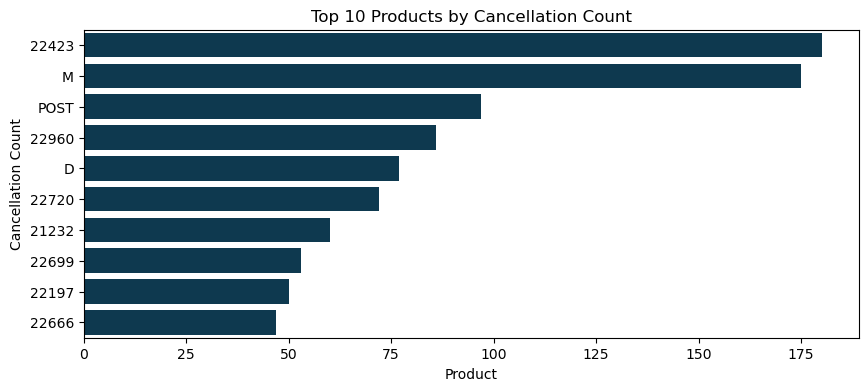

In [30]:
# Product Analysis
product_analysis = cancelled_orders.groupby('StockCode').size().reset_index(name='CancellationCount')
top_products = product_analysis.sort_values(by='CancellationCount', ascending=False).head(10)

plt.figure(figsize=(10, 4))
sns.barplot(y='StockCode', x='CancellationCount', data=top_products, orient='h', color='#033C5A')
plt.title('Top 10 Products by Cancellation Count')
plt.xlabel('Product')
plt.ylabel('Cancellation Count')
plt.show()

In [31]:
neg_invoice_merged_df = neg_invoice_df.merge(
    invoice_df,
    how='inner',
    on=['StockCode','CustomerID','UnitPrice','Country']
)

condition1 = (abs(neg_invoice_merged_df.Quantity_x) == neg_invoice_merged_df.Quantity_y)
condition2 = neg_invoice_merged_df.InvoiceDate_x >= neg_invoice_merged_df.InvoiceDate_y
neg_invoice_merged_df = neg_invoice_merged_df[condition1 & condition2 ]

invoice_match = neg_invoice_merged_df.shape[0]
all_can_invoice = neg_invoice_df.shape[0]

print(f"Percent of cancellation matches: {invoice_match/all_can_invoice*100:.2f}%")

Percent of cancellation matches: 44.56%


In [32]:
cols = ['InvoiceNo_y','StockCode','Description_y','Quantity_y','InvoiceDate_y','UnitPrice','CustomerID','Country']
pos_can_match_df = neg_invoice_merged_df[cols]
pos_can_match_df.columns = neg_invoice_df.columns
pos_can_match_df = pos_can_match_df.drop_duplicates()
pos_can_match_df = pos_can_match_df.sort_values(by=['CustomerID','StockCode','Quantity','InvoiceDate'])
pos_can_match_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
4922,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
9897,546869,21914,BLUE HARMONICA IN BOX,12,2011-03-17 16:00:00,1.25,12352.0,Norway
9894,546869,22413,METAL SIGN TAKE IT OR LEAVE IT,6,2011-03-17 16:00:00,2.95,12352.0,Norway
9891,546869,22645,CERAMIC HEART FAIRY CAKE MONEY BANK,12,2011-03-17 16:00:00,1.45,12352.0,Norway
9888,546869,22701,PINK DOG BOWL,6,2011-03-17 16:00:00,2.95,12352.0,Norway


In [33]:
# Retrieve corresponding orders of cancellations, if available

rows_to_drop = pd.DataFrame(columns=neg_invoice_df.columns)

for neg_idx, neg_row in neg_invoice_df.iterrows():

    rows_to_drop.loc[len(rows_to_drop)] = neg_row

    cond1 = pos_can_match_df.CustomerID == neg_row.CustomerID
    cond2 = pos_can_match_df.StockCode == neg_row.StockCode
    cond3 = pos_can_match_df.Quantity == abs(neg_row.Quantity)
    cond4 = pos_can_match_df.InvoiceDate <= neg_row.InvoiceDate

    temp = pos_can_match_df[cond1 & cond2 & cond3 & cond4]

    if temp.shape[0]>0:
        rows_to_drop.loc[len(rows_to_drop)] = temp.iloc[0]
        pos_can_match_df.drop(temp.index[0], inplace=True)

print(f"Number of transactions to remove: {rows_to_drop.shape[0]}")

Number of transactions to remove: 11643


In [34]:
# Remove cancellations and corresponding orders

fin_invoice_df = pd.merge(
    invoice_df, rows_to_drop,
    how='outer',
    indicator=True
).query("_merge != 'both'").drop('_merge', axis=1).reset_index(drop=True)

if (invoice_df.shape[0] - (fin_invoice_df.shape[0] + rows_to_drop.shape[0])):
    print(f"Missed records that are not removed from the original data: {missed_records}")
else:
    print("All records are removed from the original data successfully")

All records are removed from the original data successfully


## Price

In [35]:
print(f"Records with negative quantity -> {fin_invoice_df[fin_invoice_df.Quantity<0].shape[0]}")
print(f"Records with zero quantity -> {fin_invoice_df[fin_invoice_df.Quantity==0].shape[0]}")
print(f"Records with negative unit price -> {fin_invoice_df[fin_invoice_df.UnitPrice<0].shape[0]}")
print(f"Records with zero unit price -> {fin_invoice_df[fin_invoice_df.UnitPrice==0].shape[0]}")

Records with negative quantity -> 0
Records with zero quantity -> 0
Records with negative unit price -> 0
Records with zero unit price -> 40


In [36]:
# Remove records with zero unit price

fin_invoice_df = fin_invoice_df[fin_invoice_df.UnitPrice>0]
print(f"Records with zero unit price -> {fin_invoice_df[fin_invoice_df.UnitPrice==0].shape[0]}")

Records with zero unit price -> 0


## Basket Price

In [37]:
# Create TotalPrice feature

fin_invoice_df['TotalPrice'] = fin_invoice_df['UnitPrice'] * fin_invoice_df['Quantity']
fin_invoice_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.3
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [38]:
temp = fin_invoice_df.copy(deep=True)
temp['InvoiceDate'] = fin_invoice_df['InvoiceDate'].dt.strftime('%Y-%m-%d')
rollup_invoice_df = temp.groupby(
    ['CustomerID','InvoiceNo','InvoiceDate','Country']
).agg(BasketPrice=('TotalPrice', 'sum')).reset_index()
rollup_invoice_df.head()

,CustomerID,InvoiceNo,InvoiceDate,Country,BasketPrice
0,12347.0,537626,2010-12-07,Iceland,711.79
1,12347.0,542237,2011-01-26,Iceland,475.39
2,12347.0,549222,2011-04-07,Iceland,636.25
3,12347.0,556201,2011-06-09,Iceland,382.52
4,12347.0,562032,2011-08-02,Iceland,584.91


# Product Categories

In [39]:
desc = fin_invoice_df['Description']

cleaned_desc = []
for obs in desc:
    cleaned_desc.extend(hf.clean_text(obs))
    

fin_invoice_df['clean_desc'] = cleaned_desc 
unq_desc = list(set(cleaned_desc))

In [40]:
# add argument top=100 for top 100 word vocab
freq, vocab, word_to_id = hf.create_word_mappings_from_corpus(unq_desc)

In [41]:
# adding 6 more dimensions for price related features
embeddings = hf.create_embeddings(word_to_id, unq_desc, len(vocab)+6)

In [42]:
price_arr = np.zeros((len(unq_desc), 6))  
threshold = [0, 1, 2, 3, 5, 10]

for i, prod in enumerate(unq_desc):
    mean_prod_price = fin_invoice_df[ fin_invoice_df['clean_desc'] == prod]['UnitPrice'].mean()
    j = 0
    while mean_prod_price > threshold[j]:
        j+=1
        if j == len(threshold): 
            break
            
    price_arr[i][j-1] = 1

In [43]:
for i in range(price_arr.shape[1]):
    embeddings[:,len(vocab)+i] = price_arr[:,i]

## Clustering Products

In [44]:
# KMeans on CPU

for n_clusters in range(3,11):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(embeddings)
    clusters = kmeans.predict(embeddings)
    globals()[f"n_{n_clusters}"] = clusters
    silhouette_avg = silhouette_score(embeddings, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", round(silhouette_avg,2))

For n_clusters = 3 The average silhouette_score is : 0.6
For n_clusters = 4 The average silhouette_score is : 0.75
For n_clusters = 5 The average silhouette_score is : 0.87
For n_clusters = 6 The average silhouette_score is : 0.92
For n_clusters = 7 The average silhouette_score is : 0.93
For n_clusters = 8 The average silhouette_score is : 0.94
For n_clusters = 9 The average silhouette_score is : 0.94
For n_clusters = 10 The average silhouette_score is : 0.95


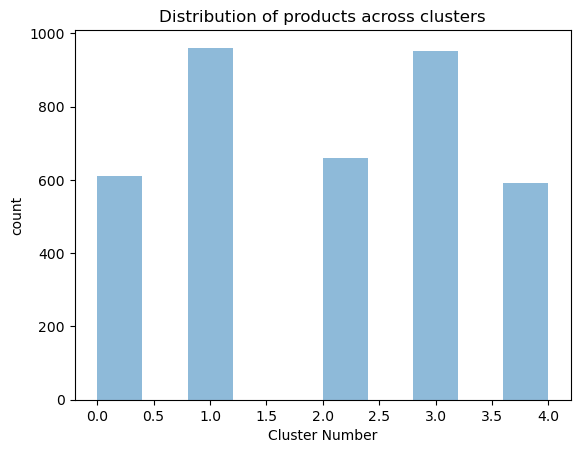

In [45]:
plt.hist(n_5, alpha=0.5)
plt.title('Distribution of products across clusters')
plt.xlabel('Cluster Number')
plt.ylabel('count')

plt.show()

In [46]:
product_cluster = pd.DataFrame({
    'clean_desc': unq_desc,
    'cluster': n_5
})
product_cluster.head()

,clean_desc,cluster
0,gingerbread man cookie cutter,1
1,triple photo frame cornice,0
2,gumball monochrome coat rack,1
3,pink hanging heart t light holder,4
4,assorted colour mini cases,0


In [47]:
product_cluster['cluster'].value_counts() 

cluster
1    961
3    953
2    661
0    612
4    593
Name: count, dtype: int64

In [48]:
fin_invoice_df = fin_invoice_df.merge(product_cluster, on=['clean_desc'])
fin_invoice_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,clean_desc,cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.3,white hanging heart t light holder,2
1,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 09:02:00,2.55,17850.0,United Kingdom,15.3,white hanging heart t light holder,2
2,536375,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 09:32:00,2.55,17850.0,United Kingdom,15.3,white hanging heart t light holder,2
3,536390,85123A,WHITE HANGING HEART T-LIGHT HOLDER,64,2010-12-01 10:19:00,2.55,17511.0,United Kingdom,163.2,white hanging heart t light holder,2
4,536394,85123A,WHITE HANGING HEART T-LIGHT HOLDER,32,2010-12-01 10:39:00,2.55,13408.0,United Kingdom,81.6,white hanging heart t light holder,2


In [49]:
fin_invoice_df['cluster'].value_counts()

cluster
1    111566
3     90035
2     80151
4     56523
0     51646
Name: count, dtype: int64

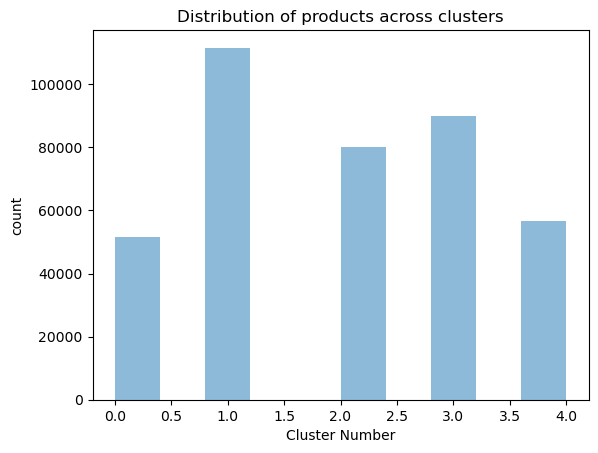

In [50]:
plt.hist(fin_invoice_df['cluster'], alpha=0.5)
plt.title('Distribution of products across clusters')
plt.xlabel('Cluster Number')
plt.ylabel('count')

plt.show()

In [51]:
# Make word Clouds

In [52]:
fin_invoice_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,clean_desc,cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.3,white hanging heart t light holder,2
1,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 09:02:00,2.55,17850.0,United Kingdom,15.3,white hanging heart t light holder,2
2,536375,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 09:32:00,2.55,17850.0,United Kingdom,15.3,white hanging heart t light holder,2
3,536390,85123A,WHITE HANGING HEART T-LIGHT HOLDER,64,2010-12-01 10:19:00,2.55,17511.0,United Kingdom,163.2,white hanging heart t light holder,2
4,536394,85123A,WHITE HANGING HEART T-LIGHT HOLDER,32,2010-12-01 10:39:00,2.55,13408.0,United Kingdom,81.6,white hanging heart t light holder,2


In [53]:
!pip install wordcloud


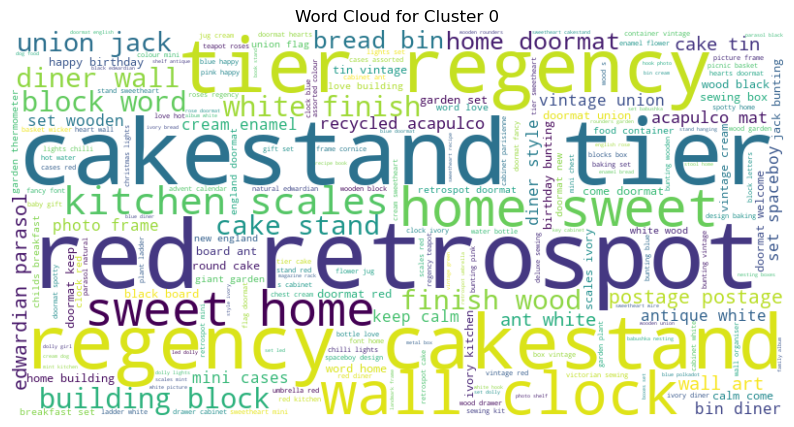

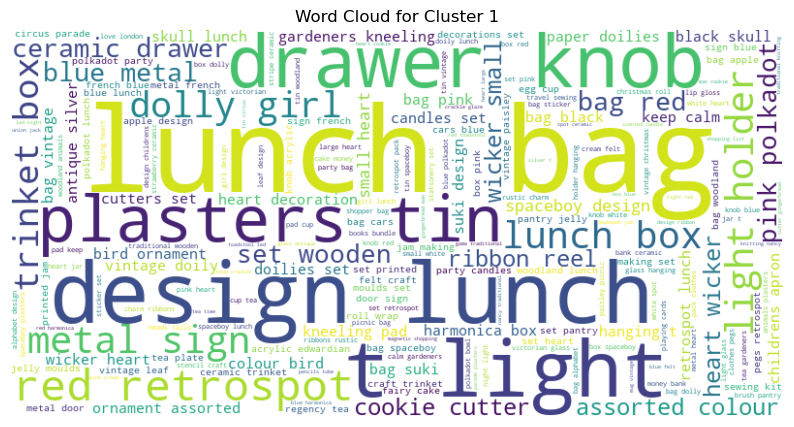

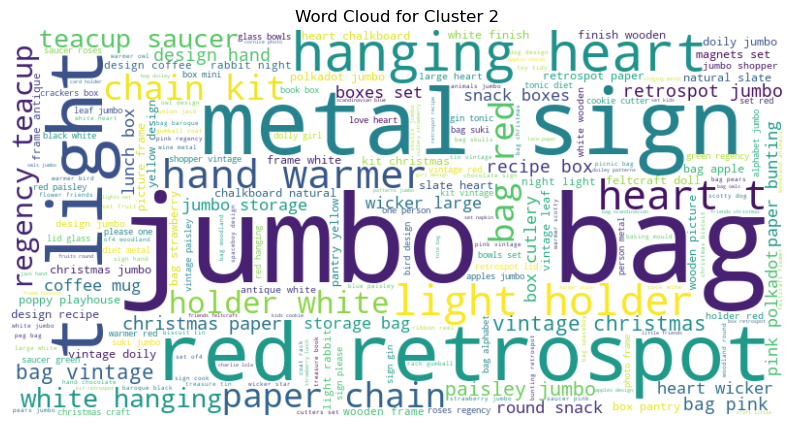

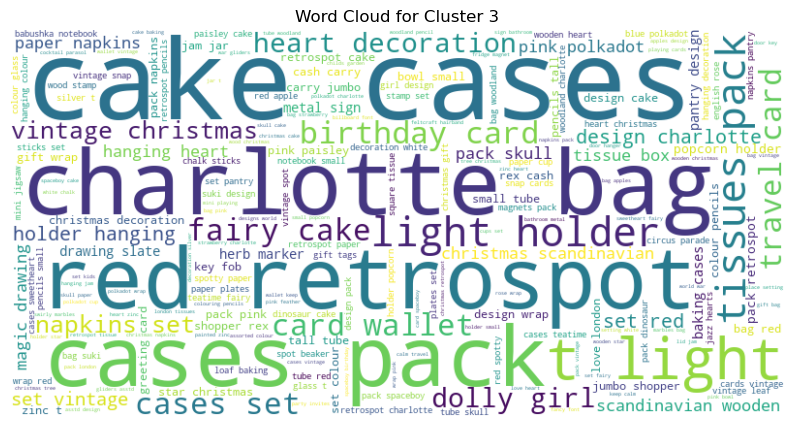

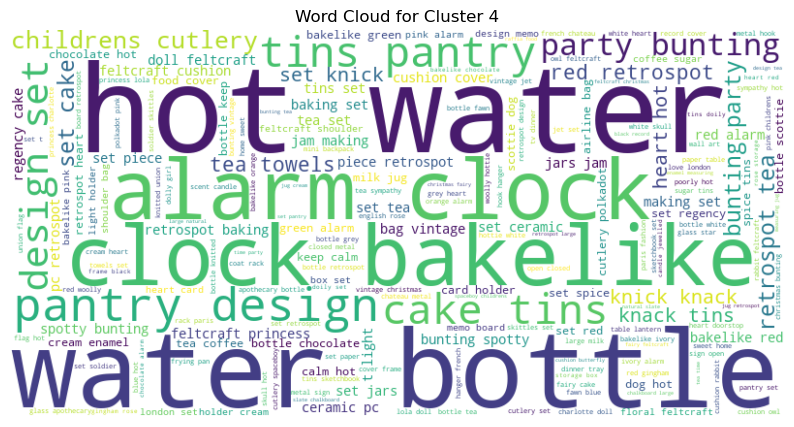

In [54]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming 'your_dataset.csv' is your dataset file
df = fin_invoice_df.copy()

# Function to generate word cloud for a specific cluster
def generate_wordcloud(cluster):
    # Filter the DataFrame for the specified cluster
    cluster_data = df[df['cluster'] == cluster]

    # Combine all descriptions for the cluster into a single string
    text = ' '.join(cluster_data['clean_desc'])

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Plot the WordCloud image
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster}')
    plt.show()

clusters_to_visualize = set(df['cluster'])

# Generate word cloud for each specified cluster
for cluster in clusters_to_visualize:
    generate_wordcloud(cluster)


## PCA

# Customer Categories

In [55]:
temp = fin_invoice_df.copy(deep=True)

In [56]:
for i in range(5):
    col = 'C{}'.format(i)        
    df_temp = temp[temp['cluster'] == i]
    price_temp = df_temp['TotalPrice']
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    temp.loc[:, col] = price_temp
    temp[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
temp[['CustomerID', 'InvoiceNo', 'Description', 'cluster', 'C0', 'C1', 'C2', 'C3','C4']][:5]

,CustomerID,InvoiceNo,Description,cluster,C0,C1,C2,C3,C4
0,17850.0,536365,WHITE HANGING HEART T-LIGHT HOLDER,2,0.0,0.0,15.3,0.0,0.0
1,17850.0,536373,WHITE HANGING HEART T-LIGHT HOLDER,2,0.0,0.0,15.3,0.0,0.0
2,17850.0,536375,WHITE HANGING HEART T-LIGHT HOLDER,2,0.0,0.0,15.3,0.0,0.0
3,17511.0,536390,WHITE HANGING HEART T-LIGHT HOLDER,2,0.0,0.0,163.2,0.0,0.0
4,13408.0,536394,WHITE HANGING HEART T-LIGHT HOLDER,2,0.0,0.0,81.6,0.0,0.0


In [57]:
customer_df = temp.groupby(
    ['CustomerID','InvoiceNo','InvoiceDate','Country']
).agg(
    TransCount=('InvoiceNo', 'count'),
    C0 = ('C0','sum'),
    C1 = ('C1','sum'),
    C2 = ('C2','sum'),
    C3 = ('C3','sum'),
    C4 = ('C4','sum'),
    TotalPrice = ('TotalPrice','sum')
).reset_index()
customer_df.head()

,CustomerID,InvoiceNo,InvoiceDate,Country,TransCount,C0,C1,C2,C3,C4,TotalPrice
0,12347.0,537626,2010-12-07 14:57:00,Iceland,31,124.44,169.8,83.40,40.80,293.35,711.79
1,12347.0,542237,2011-01-26 14:30:00,Iceland,29,38.25,130.5,53.10,84.34,169.20,475.39
2,12347.0,549222,2011-04-07 10:43:00,Iceland,24,38.25,330.9,71.10,81.00,115.00,636.25
3,12347.0,556201,2011-06-09 13:01:00,Iceland,18,19.90,74.4,78.06,41.40,168.76,382.52
4,12347.0,562032,2011-08-02 08:48:00,Iceland,22,136.05,109.7,119.70,61.30,158.16,584.91


In [58]:
# basket_price = basket_price[basket_price['Basket Price'] > 0]
customer_df.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,InvoiceDate,Country,TransCount,C0,C1,C2,C3,C4,TotalPrice
0,12347.0,537626,2010-12-07 14:57:00,Iceland,31,124.44,169.8,83.40,40.80,293.35,711.79
1,12347.0,542237,2011-01-26 14:30:00,Iceland,29,38.25,130.5,53.10,84.34,169.20,475.39
2,12347.0,549222,2011-04-07 10:43:00,Iceland,24,38.25,330.9,71.10,81.00,115.00,636.25
3,12347.0,556201,2011-06-09 13:01:00,Iceland,18,19.90,74.4,78.06,41.40,168.76,382.52
4,12347.0,562032,2011-08-02 08:48:00,Iceland,22,136.05,109.7,119.70,61.30,158.16,584.91


In [59]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18460 entries, 0 to 18459
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   CustomerID   18460 non-null  float64       
 1   InvoiceNo    18460 non-null  object        
 2   InvoiceDate  18460 non-null  datetime64[ns]
 3   Country      18460 non-null  object        
 4   TransCount   18460 non-null  int64         
 5   C0           18460 non-null  float64       
 6   C1           18460 non-null  float64       
 7   C2           18460 non-null  float64       
 8   C3           18460 non-null  float64       
 9   C4           18460 non-null  float64       
 10  TotalPrice   18460 non-null  object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(3)
memory usage: 1.5+ MB


## Customer order Combinations

In [60]:
current_date = customer_df['InvoiceDate'].max()

In [61]:
rfm_df = customer_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',                                   # Frequency
    'TransCount': 'sum',
    'TotalPrice': ['sum', 'min', 'max', 'mean'] ,                                     # Monetary
    'C0': 'sum',
    'C1': 'sum',
    'C2': 'sum',
    'C3': 'sum',
    'C4': 'sum'
}).reset_index()

In [62]:
rfm_df.head()

CustomerID InvoiceDate InvoiceNo TransCount TotalPrice                    \
                <lambda>     count        sum        sum      min      max   
0    12347.0           1         7        182     4310.0   224.82  1294.32   
1    12348.0          74         4         31    1797.24   227.44    892.8   
2    12349.0          18         1         73    1757.55  1757.55  1757.55   
3    12350.0         309         1         17      334.4    334.4    334.4   
4    12352.0          35         8         78    2385.71     19.8    840.3   

                    C0       C1      C2      C3       C4  
         mean      sum      sum     sum     sum      sum  
0  615.714286   518.99  1119.40  896.70  501.72  1273.19  
1      449.31   360.00   754.00    0.00  683.24     0.00  
2     1757.55   808.85   465.86  215.22   79.32   188.30  
3       334.4    40.00   144.60   93.30   56.50     0.00  
4   298.21375  1534.55   374.68   97.13   31.00   348.35

In [63]:
# rfm_df.columns = ['_'.join(col).strip() for col in rfm_df.columns.values]
# rfm_df = rfm_df.rename(columns={
#     'TotalPrice_sum': 'Monetary_Total',
#     'TotalPrice_min': 'Monetary_Min',
#     'TotalPrice_max': 'Monetary_Max',
#     'TotalPrice_mean': 'Monetary_Mean'
# })

rfm_df.columns = [
    'CustomerID', 'Recency','InvoiceNo_count', 'TransCount',
    'Monetary_Total', 'Monetary_Min', 'Monetary_Max', 'Monetary_Mean',
    'C0_sum', 'C1_sum', 'C2_sum', 'C3_sum', 'C4_sum'
]


In [64]:
rfm_df = rfm_df.merge(customer_cancellations, how='left', on=['CustomerID'])
rfm_df.fillna('0', inplace=True)
rfm_df['Monetary_Total'] = pd.to_numeric(rfm_df['Monetary_Total'])
rfm_df['cancel_cnt'] = pd.to_numeric(rfm_df['cancel_cnt'])
rfm_df['cancel_amt'] = pd.to_numeric(rfm_df['cancel_amt'])
rfm_df['Revenue_Lost_Ratio'] = np.round(rfm_df['cancel_amt'] / rfm_df['Monetary_Total'], 2)
rfm_df.head(n=10)

,CustomerID,Recency,InvoiceNo_count,TransCount,Monetary_Total,Monetary_Min,Monetary_Max,Monetary_Mean,C0_sum,C1_sum,C2_sum,C3_sum,C4_sum,cancel_cnt,cancel_amt,Revenue_Lost_Ratio
0,12347.0,1,7,182,4310.00,224.82,1294.32,615.714286,518.99,1119.40,896.70,501.72,1273.19,0.0,0.00,0.0
1,12348.0,74,4,31,1797.24,227.44,892.8,449.31,360.00,754.00,0.00,683.24,0.00,0.0,0.00,0.0
2,12349.0,18,1,73,1757.55,1757.55,1757.55,1757.55,808.85,465.86,215.22,79.32,188.30,0.0,0.00,0.0
3,12350.0,309,1,17,334.40,334.4,334.4,334.4,40.00,144.60,93.30,56.50,0.00,0.0,0.00,0.0
4,12352.0,35,8,78,2385.71,19.8,840.3,298.21375,1534.55,374.68,97.13,31.00,348.35,10.0,960.63,0.4
5,12353.0,203,1,4,89.00,89.0,89.0,89.0,59.70,11.60,17.70,0.00,0.00,0.0,0.00,0.0
6,12354.0,231,1,58,1079.40,1079.4,1079.4,1079.4,252.00,336.52,116.85,161.38,212.65,0.0,0.00,0.0
7,12355.0,213,1,13,459.40,459.4,459.4,459.4,45.40,244.80,53.10,0.00,116.10,0.0,0.00,0.0
8,12356.0,22,3,59,2811.43,58.35,2271.62,937.143333,1066.83,788.95,353.90,397.75,204.00,0.0,0.00,0.0
9,12357.0,32,1,131,6207.67,6207.67,6207.67,6207.67,2073.35,1146.90,911.58,315.96,1759.88,0.0,0.00,0.0


## Clustering on Customers

In [65]:
# including Recency

For n_clusters = 3 The average silhouette_score is : 0.95
For n_clusters = 4 The average silhouette_score is : 0.86
For n_clusters = 5 The average silhouette_score is : 0.37
For n_clusters = 6 The average silhouette_score is : 0.36
For n_clusters = 7 The average silhouette_score is : 0.38
For n_clusters = 8 The average silhouette_score is : 0.38
For n_clusters = 9 The average silhouette_score is : 0.41


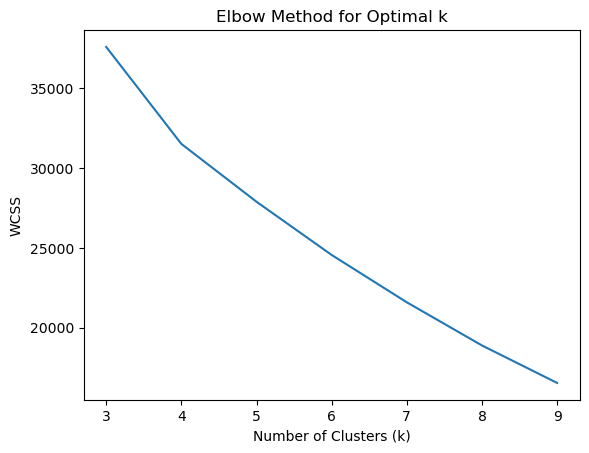

Give best Cluster 4


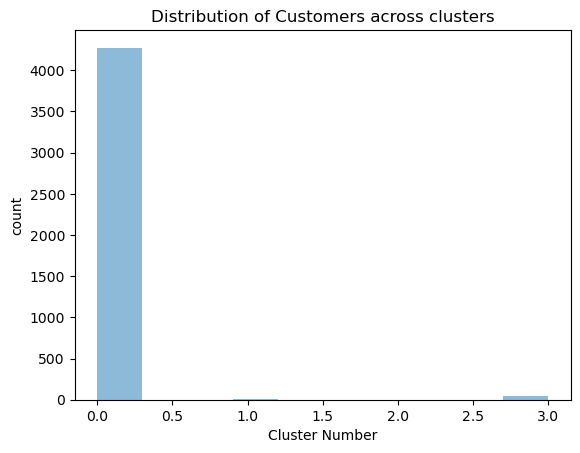

In [120]:
feature_names = [
    'Recency', 'TransCount', 'Monetary_Total', 
    'Monetary_Min', 'Monetary_Max', 'Monetary_Mean', 
    'C0_sum', 'C1_sum', 'C2_sum', 'C3_sum', 'C4_sum', 
    'cancel_cnt', 'cancel_amt', 'Revenue_Lost_Ratio'
]
title = 'Distribution of Customers across clusters'
hf.get_kmeans(rfm_df, feature_names, 10, title, plot = True )


In [68]:
# Excluding Recency

In [82]:
customer_clusters = pd.DataFrame({
    'CustomerID': rfm_df['CustomerID'],
    'cluster': n_5
})
customer_clusters['cluster'].value_counts()

cluster
0    4281
2      39
3       5
1       1
4       1
Name: count, dtype: int64

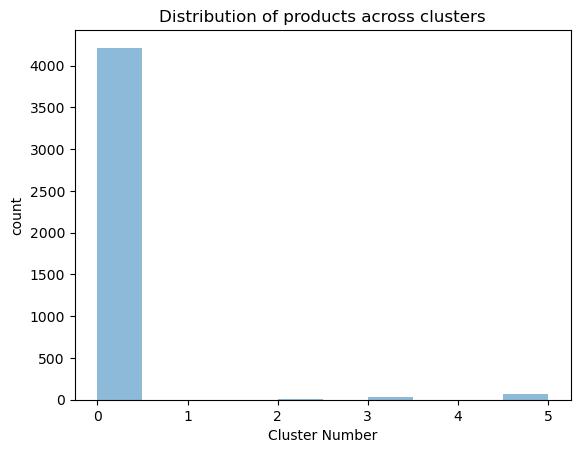

In [87]:
plt.hist(n_6, alpha=0.5)
plt.title('Distribution of products across clusters')
plt.xlabel('Cluster Number')
plt.ylabel('count')

plt.show()

For n_clusters = 3 The average silhouette_score is : 0.95
For n_clusters = 4 The average silhouette_score is : 0.9
For n_clusters = 5 The average silhouette_score is : 0.9


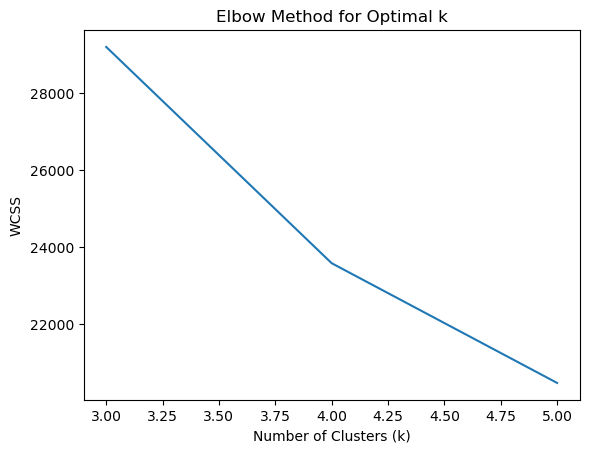

Give best Cluster 3


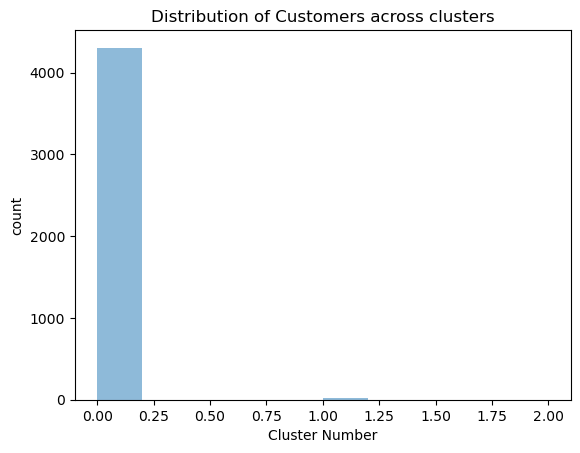

In [117]:
feature_names = [
    'Monetary_Total', 
    'Monetary_Min', 'Monetary_Max', 'Monetary_Mean', 
    'C0_sum', 'C1_sum', 'C2_sum', 'C3_sum', 'C4_sum', 
    'cancel_cnt', 'cancel_amt', 'Revenue_Lost_Ratio'
]
title = 'Distribution of Customers across clusters'
hf.get_kmeans(rfm_df, feature_names, 10, title, plot = True )


For n_clusters = 3 The average silhouette_score is : 0.95
For n_clusters = 4 The average silhouette_score is : 0.9
For n_clusters = 5 The average silhouette_score is : 0.9
For n_clusters = 6 The average silhouette_score is : 0.75
For n_clusters = 7 The average silhouette_score is : 0.75
For n_clusters = 8 The average silhouette_score is : 0.75
For n_clusters = 9 The average silhouette_score is : 0.54


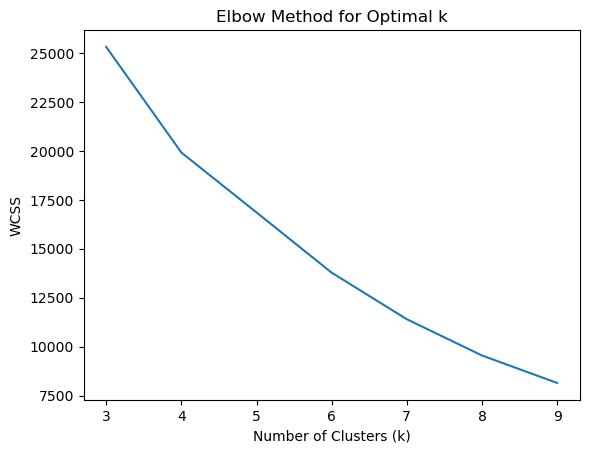

Give best Cluster 5


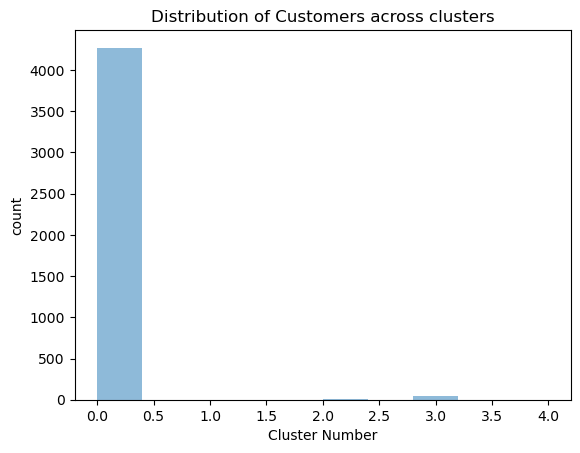

In [118]:
feature_names = [
    'Monetary_Total', 
    'Monetary_Min', 'Monetary_Max', 'Monetary_Mean', 
    'C0_sum', 'C1_sum', 'C2_sum', 'C3_sum', 'C4_sum', 
    'cancel_amt', 'Revenue_Lost_Ratio'
]
title = 'Distribution of Customers across clusters'
hf.get_kmeans(rfm_df, feature_names, 10, title, plot = True )

For n_clusters = 3 The average silhouette_score is : 0.9
For n_clusters = 4 The average silhouette_score is : 0.9
For n_clusters = 5 The average silhouette_score is : 0.76
For n_clusters = 6 The average silhouette_score is : 0.63
For n_clusters = 7 The average silhouette_score is : 0.75
For n_clusters = 8 The average silhouette_score is : 0.54
For n_clusters = 9 The average silhouette_score is : 0.5


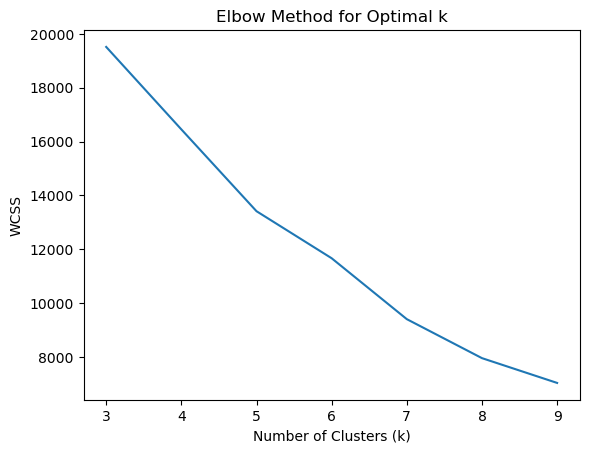

Give best Cluster 4


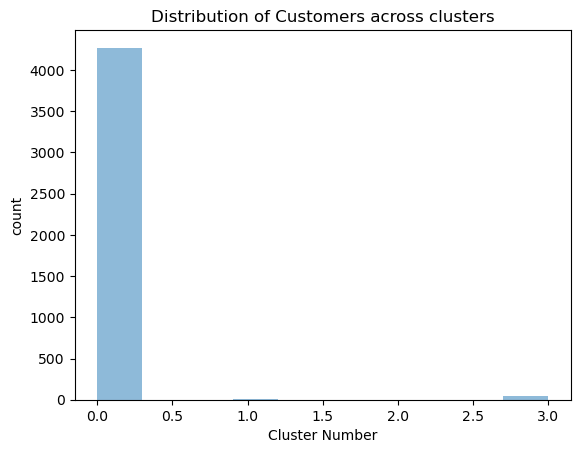

In [119]:
feature_names = [
    'Monetary_Total', 
    'Monetary_Min', 'Monetary_Max', 'Monetary_Mean', 
    'C0_sum', 'C1_sum', 'C2_sum', 'C3_sum', 'C4_sum', 
]
title = 'Distribution of Customers across clusters'
hf.get_kmeans(rfm_df, feature_names, 10, title, plot = True )

In [149]:
from sklearn.feature_selection import VarianceThreshold

from sklearn.feature_selection import SelectKBest, mutual_info_classif



feature_names = [
    'Recency', 'TransCount', 'Monetary_Total', 
    'Monetary_Min', 'Monetary_Max', 'Monetary_Mean', 
    'C0_sum', 'C1_sum', 'C2_sum', 'C3_sum', 'C4_sum', 
    'cancel_cnt', 'cancel_amt', 'Revenue_Lost_Ratio'
]
X = rfm_df
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

correlation_matrix = X.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.7)]
X_selected = X.drop(columns=to_drop)
selected_feature_names = [feature_names[i] for i in range(len(feature_names)) if feature_names[i] not in to_drop]

print("Selected features:", selected_feature_names)

Selected features: ['Recency', 'Monetary_Total', 'Monetary_Min', 'cancel_cnt', 'cancel_amt']


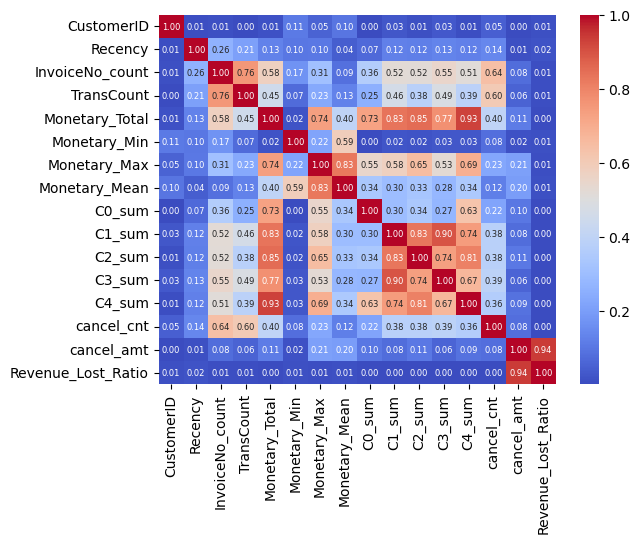

In [150]:
import seaborn as sns

annot_kws = {'size': 6}
sns.heatmap(correlation_matrix,  annot=True, cmap='coolwarm', fmt='.2f',annot_kws=annot_kws)
plt.show()

For n_clusters = 3 The average silhouette_score is : 0.47
For n_clusters = 4 The average silhouette_score is : 0.49
For n_clusters = 5 The average silhouette_score is : 0.48
For n_clusters = 6 The average silhouette_score is : 0.52
For n_clusters = 7 The average silhouette_score is : 0.52
For n_clusters = 8 The average silhouette_score is : 0.53
For n_clusters = 9 The average silhouette_score is : 0.53


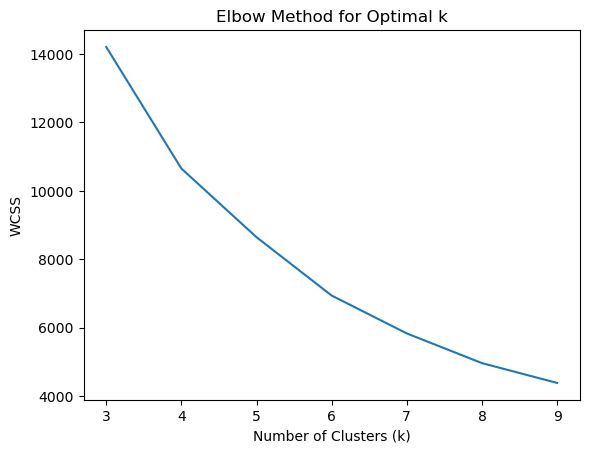

Give best Cluster 8


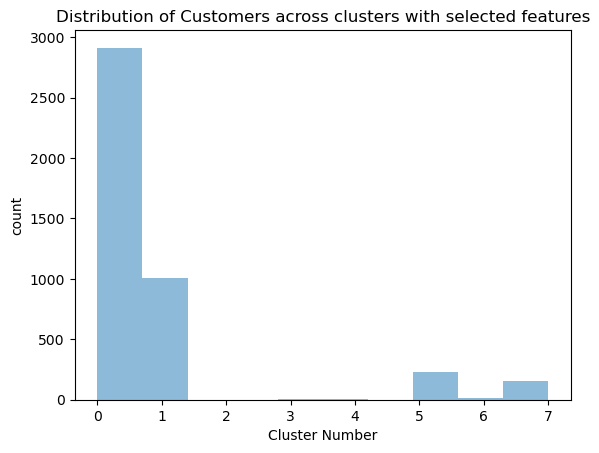

In [152]:


title = 'Distribution of Customers across clusters with selected features'
hf.get_kmeans(rfm_df, selected_feature_names, 10, title, plot = True )

In [144]:
threshold = 0.9
selector = VarianceThreshold(threshold=threshold)
X_selected = selector.fit_transform(X)
selected_feature_names = [feature_names[i] for i in range(len(feature_names)) if selector.get_support()[i]]

print("Selected features:", selected_feature_names)

Selected features: ['Recency', 'TransCount', 'Monetary_Total', 'Monetary_Min', 'Monetary_Max', 'Monetary_Mean', 'C0_sum', 'C1_sum', 'C2_sum', 'C3_sum', 'C4_sum', 'cancel_cnt', 'cancel_amt', 'Revenue_Lost_Ratio']


# Classification on Customers